In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from mude_tools import magicplotter
%matplotlib widget

## Introduction

A very general problem often encountered is predicting some target variable $t$ as a function of a predictor variable $x$, but we only have inaccurate measurements of our target variable. Some examples of possible problems where we can apply this kind of framework are given below:

| Problem | Target variable $t$ | Predictor variable $x$ |
| :-- | :-- | :-- |
| Structural health monitoring of a bridge | Displacement| Location along the bridge |
| Fatigue testing of a steel specimen | Stress | Number of loading cycles |
| Flood control of the river Maas | Volumetric flow rate | Precipitation in the Ardennes |
| Radioactive decay of a radon-222 sample | Number of $\alpha$-particles emitted | Time |
| Cooling rate of my coffee cup | Temperature | Time |

To strip the problem down to its bare essentials, we will use a toy problem, where we actually know the ground truth $f(x)$. In our case, this will be a simple sine wave, of which we make 100 noisy measurements from $x=0$ to $x=2 \pi$. Note that we only have access to these measurements in a practical setting, not to the true function that generated the data. Finding a good estimate of $f(x)$ is one of our main objectives.

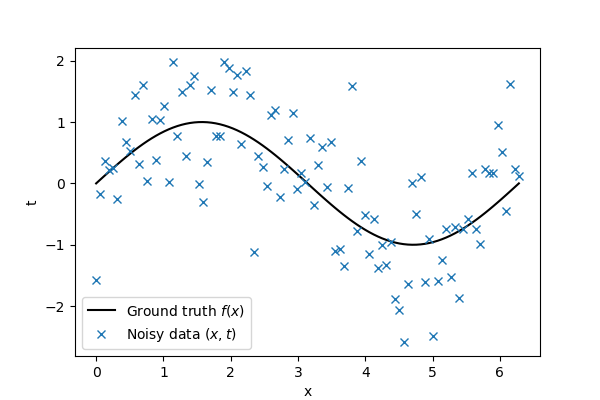

In [2]:
# The true function relating t to x
def f_truth(x, freq=1, **kwargs):
    
    # Return a sine with a frequency of freq
    return np.sin(x * freq)

# The data generation function
def f_data(epsilon=0.7, N=100, **kwargs):

    # Apply a seed if one is given
    if 'seed' in kwargs:
        np.random.seed(kwargs['seed'])

    # Get the minimum and maximum
    xmin = kwargs.get('xmin', 0)
    xmax = kwargs.get('xmax', 2*np.pi)
    
    # Generate N evenly spaced observation locations
    x = np.linspace(xmin, xmax, N)
    
    # Generate N noisy observations (1 at each location)
    t = f_truth(x, **kwargs) + np.random.normal(0, epsilon, N)
    
    # Return both the locations and the observations
    return x, t

# Get the observed data
x, t = f_data()

# Plot the data and the ground truth
plt.figure(figsize=(6,4))

plt.plot(x, f_truth(x), 'k-', label=r'Ground truth $f(x)$')
plt.plot(x, t, 'x', label=r'Noisy data $(x,t)$')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()

plt.show()

## k-nearest neighbors

A (perhaps naive) approach to find $y(x)$ (i.e. the approximation of $f(x)$) would be to simply look at the surrounding data points and take their average to get an estimate of $f(x)$. This approach is called __k-nearest neighbors__, where $k$ refers to the number of surrounding points we are looking at.

Implementing this is not trivial, but thankfully other people have made implementations for us. We will use the `KNeighborsRegressor` function from the `sklearn.neighbors` library to fit our data and get $y(x)$ to make predictions.

In [3]:
# Define the prediction locations
# (note that these are different from the locations where we observed our data)
x_pred = np.linspace(0, 2*np.pi, 1000)

# Define a function that makes a KNN prediction at the given locations, based on the given (x,t) data
def KNN(x, t, x_pred, k=1, **kwargs):
    
    # Convert x and x_pred to a column vector in order for KNeighborsRegresser to work
    X = x.reshape(-1,1)
    X_pred = x_pred.reshape(-1,1)
    
    # Train the KNN based on the given (x,t) data
    neigh = KNeighborsRegressor(k)
    neigh.fit(X, t)
    
    # Make a prediction at the locations given by x_pred
    y = neigh.predict(X_pred)
    
    # Check if the regressor itself should be returned
    if kwargs.get('return_regressor', False):

        # If so, return the fitted KNN regressor
        return neigh

    else:

        # If not, return the predicted values
        return y

We visualize the predictions with the help of the `magicplotter` object, which functions as a wrapper for `matplotlib` and enables us to reduce the amount of code contained in this notebook significantly. You do not need to understand how it works, but you can take a look at it via the course repository.

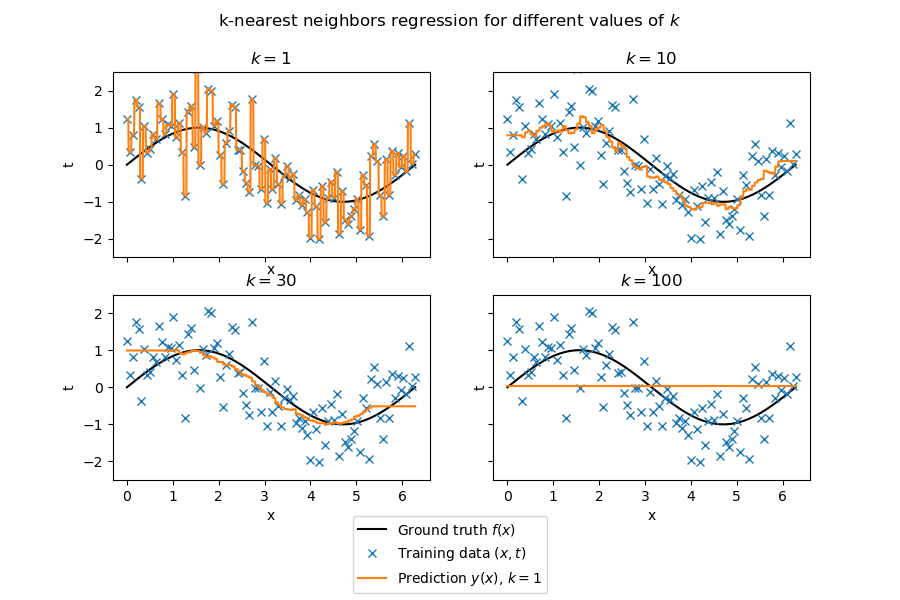

In [4]:
# Plot the resulting predictions
fig, ax = plt.subplots(2, 2, figsize=(9,6), sharex='all', sharey='all') 
plt.suptitle(r'k-nearest neighbors regression for different values of $k$')

# Plot for k=1
magicplotter(f_data, f_truth, KNN, x_pred, k=1, ax=ax[0][0], hide_legend=True, title=r'$k={k}$')

# Plot for k=10
magicplotter(f_data, f_truth, KNN, x_pred, k=10, ax=ax[0][1], hide_legend=True, title=r'$k={k}$')

# Plot for k=30
magicplotter(f_data, f_truth, KNN, x_pred, k=30, ax=ax[1][0], hide_legend=True, title=r'$k={k}$')

# Plot for k=100
magicplotter(f_data, f_truth, KNN, x_pred, k=100, ax=ax[1][1], hide_legend=True, title=r'$k={k}$')

# Add a general legend at the bottom of the plot
plt.subplots_adjust(bottom=0.2)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')

plt.show()

Looking at the previous plots, a few questions might pop up:
- For $k=1$, we see that our prediction matches the observed data exactly in all data points. Is this desirable?
- For $k=30$, what is going on around $x=0$ and $x=2 \pi$?
- For $k=100$, why is our prediction constant with respect to $x$?

## Varying our model parameters

Clearly, some value of $k$ between 1 and 100 would give us the best predictions. Using the script below, you can generate a plot where the following variables can be adjusted:
- $k$, the number of neighbors over which the average is taken
- $N$, the size of the training data set
- $l$, the wavelength of the underlying truth
- $\varepsilon$, the level of noise associated with the data
- The seed can be updated to generate new random data sets
- The truth can be hidden to simulate a situation that is closer to a practical setting

Understanding the magicplotter object we included is not necessary; it simply generates the interactive plot.

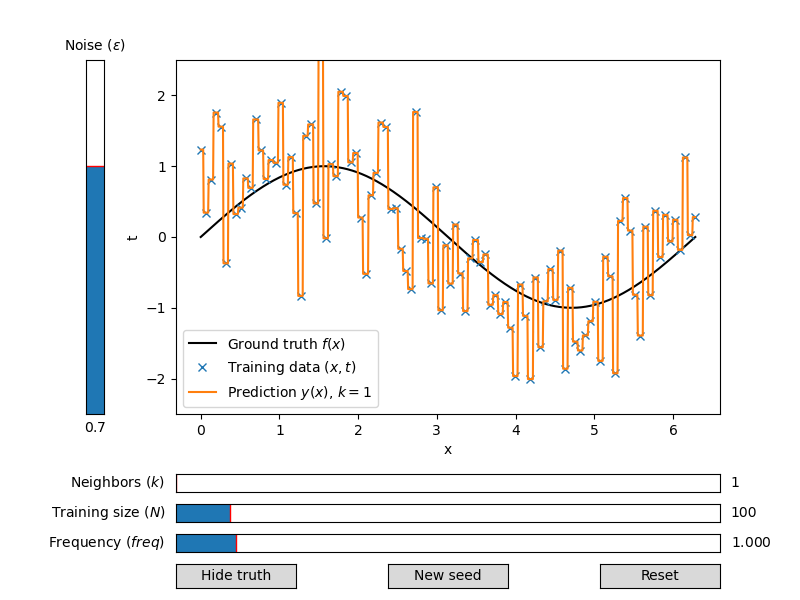

In [5]:
plot1 = magicplotter(f_data, f_truth, KNN, x_pred)
plot1.add_sliders('epsilon', 'k', 'N', 'freq')
plot1.add_buttons('truth', 'seed', 'reset')
plot1.add_probe()
plot1.show()

## Playing around with the plots

By visual inspection, use the slider of $k$ to find its optimal value. The following questions might be interesting to ask yourself:
- If the training size $N$ increases/decreases, how does this affect my optimal value of $k$?
- If the wavelength $l$ increases/decreases, how does this affect my optimal value of $k$?
- If my measurements are less/more noisy, how does this affect my optimal value of $k$?
- If I generate new data by changing the seed, how is my prediction affected for small values of $k$? What about large values of $k$?
- If I do not know the truth, how do I figure out my value of $k$ should be?
- So far, all observations were distributed uniformly over $x$. How would our predictions change if our observed data was more clustered?

## Final remarks
So far, we have looked at our k-nearest neighbors regressor mostly qualitatively. However, it is possible to apply a more quantitative framework to our model and find the optimal value for $k$ in a more structured way. The following lecture will discuss how this is done and its accompanying notebook!